Load up data

In [158]:
import csv
import numpy as np
from collections import defaultdict
import sklearn
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from itertools import groupby
from operator import itemgetter
from functools import reduce
import scipy
import matplotlib.pyplot as plt
# train_data_raw will have [(id, [metadata])]
train_data_raw = []

# all labels
y = []

# will have (id, title)
train_id_title = []

# contains imdbid, year, runtime, score
otherData = np.zeros([3094, 4])

imdbid = []

with open('train_data.csv') as trainCSV:
    reader = csv.reader(trainCSV, delimiter=',')
    i = 0 
    for row in reader:
        # skip the first row
        if (row[1] == 'imdbId'):
            continue
        id = int(row[0])
        train_data_raw.append((id, row[1:]))
        train_id_title.append((id, row[2]))
        y.append(int(row[6]))
        otherData[i, :] = np.array([float(row[1]), float(row[3]), float(row[4]), float(row[5])])
        i += 1
                      
y = np.array(y)

In [159]:
# assign colors to our labels for visualizations
def colorizer(x):
    # action/adv
    if (x==0):
        return 'r'
    # romance/comedy
    if (x==1):
        return 'b'
    #drama/crime
    if (x==2):
        return 'g'
    #biography/doc
    if (x==3):
        return 'y'
    
colors = np.array(list(map(colorizer, y)))

We're going to vectorize the titles using TFIDF

In [160]:
# we're treating titles as TF-IDF vectors
titles = [title[1] for title in train_id_title]
vectorizer = TfidfVectorizer(strip_accents='unicode')

# get data mtx
Xtfidf = np.asarray(vectorizer.fit_transform(titles).todense())

In [68]:
X = Xtfidf

In [69]:
# center data
Xc = X - np.mean(X, axis=0)

# PCA via SVDz
(u, s, vh) = scipy.linalg.svd(Xc)

In [70]:
# projection matrix
W = vh.T
Xc_proj = Xc.dot(W)

In [71]:
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


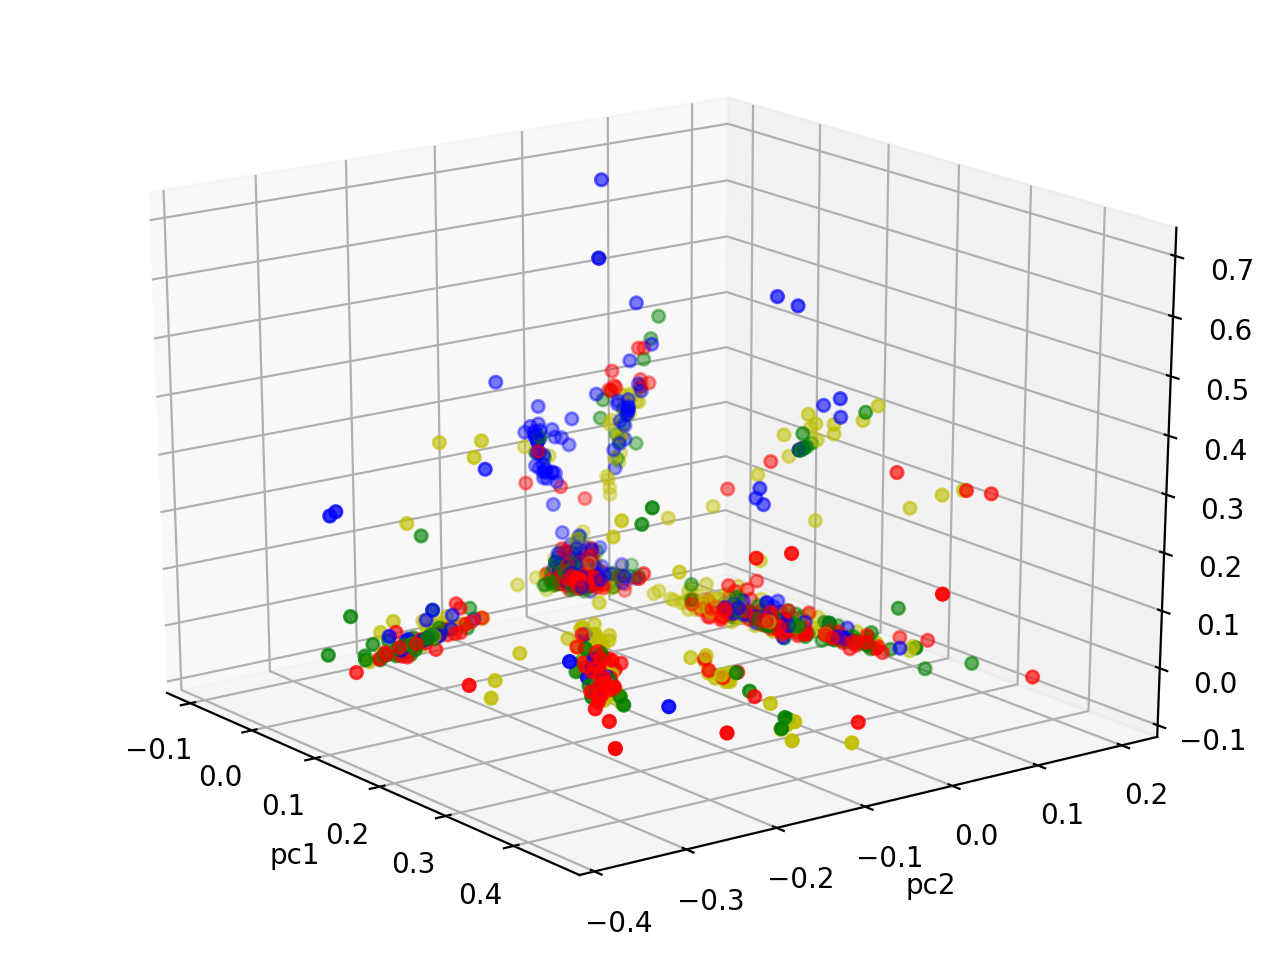

Text(0.5, 0, 'pc2')

In [106]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(Xc_proj[:,0], Xc_proj[:,1], zs=Xc_proj[:,2], c=colors)
plt.xlabel('pc1')
plt.ylabel('pc2')

<IPython.core.display.Javascript object>


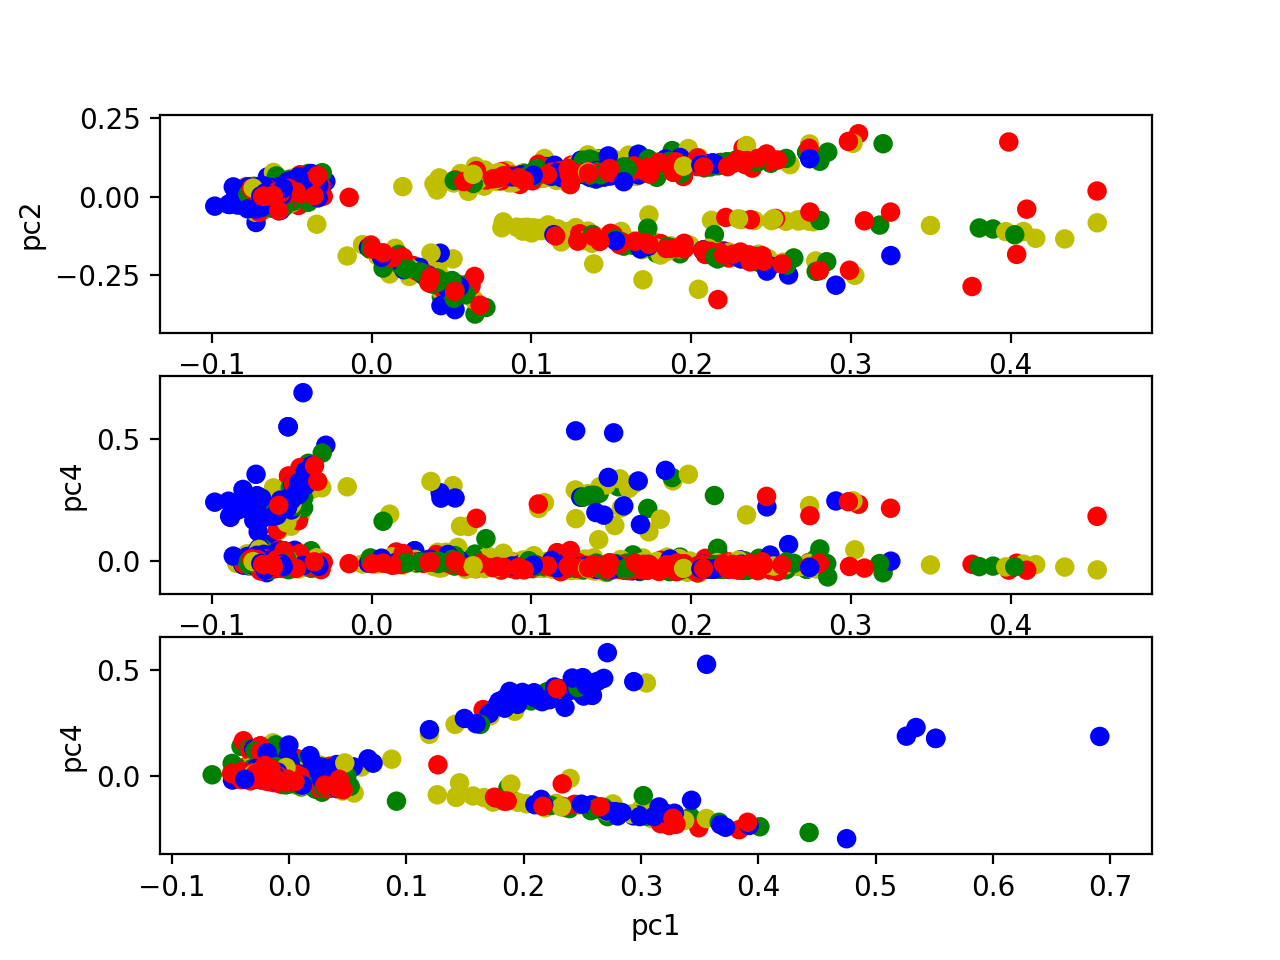

Text(0, 0.5, 'pc4')

In [107]:
fig1 = plt.figure()
plt.subplot(3,1, 1)
plt.scatter(Xc_proj[:,0], Xc_proj[:,1], c=colors)
plt.xlabel('pc1')
plt.ylabel('pc2')

plt.subplot(3,1, 2)
plt.scatter(Xc_proj[:,0], Xc_proj[:,2], c=colors)
plt.xlabel('pc1')
plt.ylabel('pc4')

plt.subplot(3,1, 3)
plt.scatter(Xc_proj[:,2], Xc_proj[:,3], c=colors)
plt.xlabel('pc1')
plt.ylabel('pc4')

The titles seem to not carry a lot of information regarding the class. It does kind of seem like title may be good for picking out romance/comedy.

### Now, we're dealing just with the extra metadata.

In [147]:
# centering 
# contains imdbid, year, runtime, score
otherDatac = otherData - np.mean(otherData, axis=0)

<IPython.core.display.Javascript object>


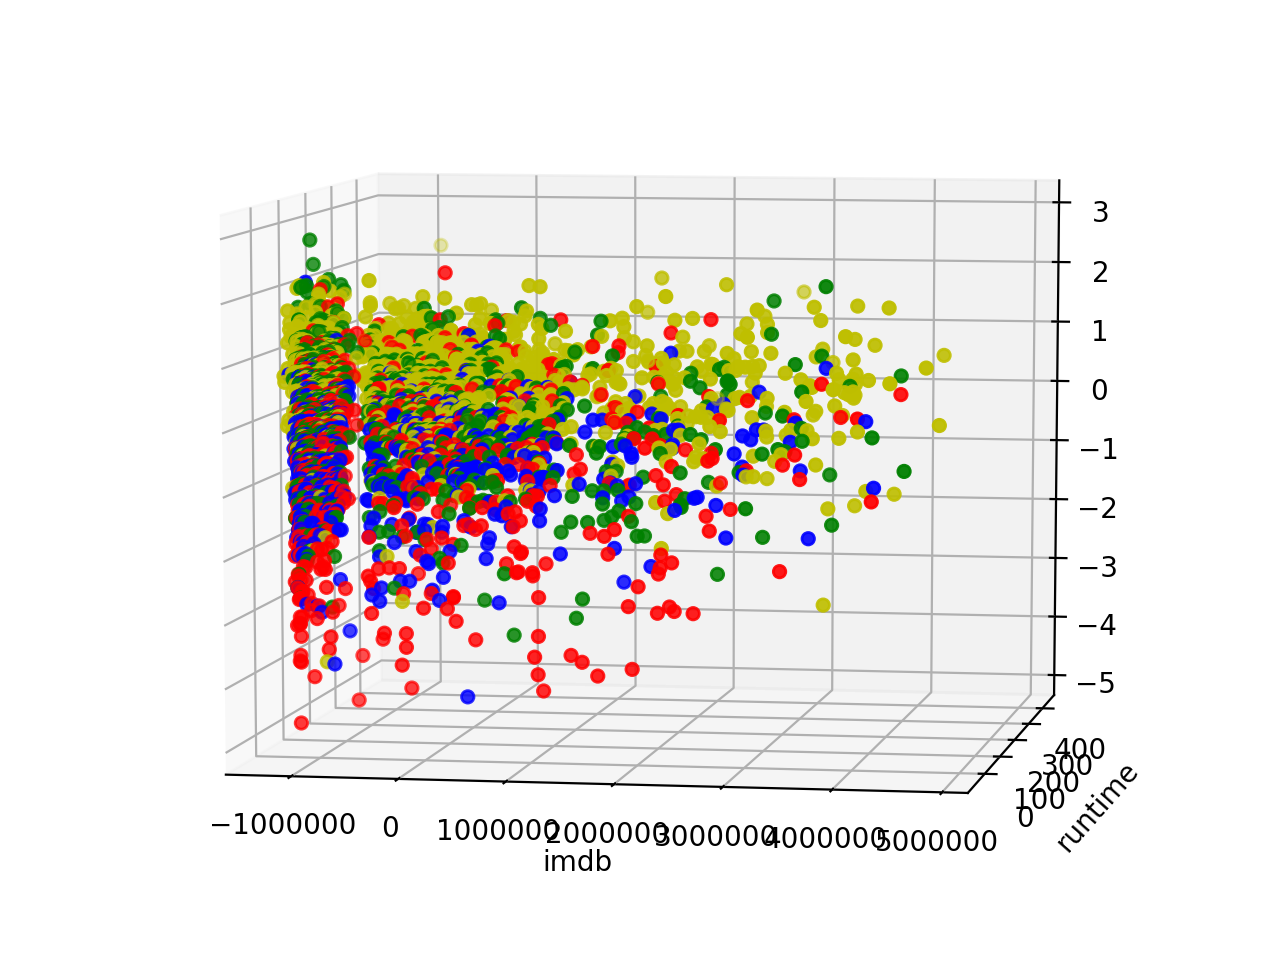

Text(0.5, 0, 'runtime')

In [152]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(otherDatac[:,0], otherDatac[:,2], zs=otherDatac[:,3], c=colors)
plt.xlabel('imdb')
plt.ylabel('runtime')

Plotted release year in place of iMDb id before hand. Release year has a very useless spread. iMDb id is almost as useless, but there is a slight trend.

Let's look at just runtime and year.

<IPython.core.display.Javascript object>


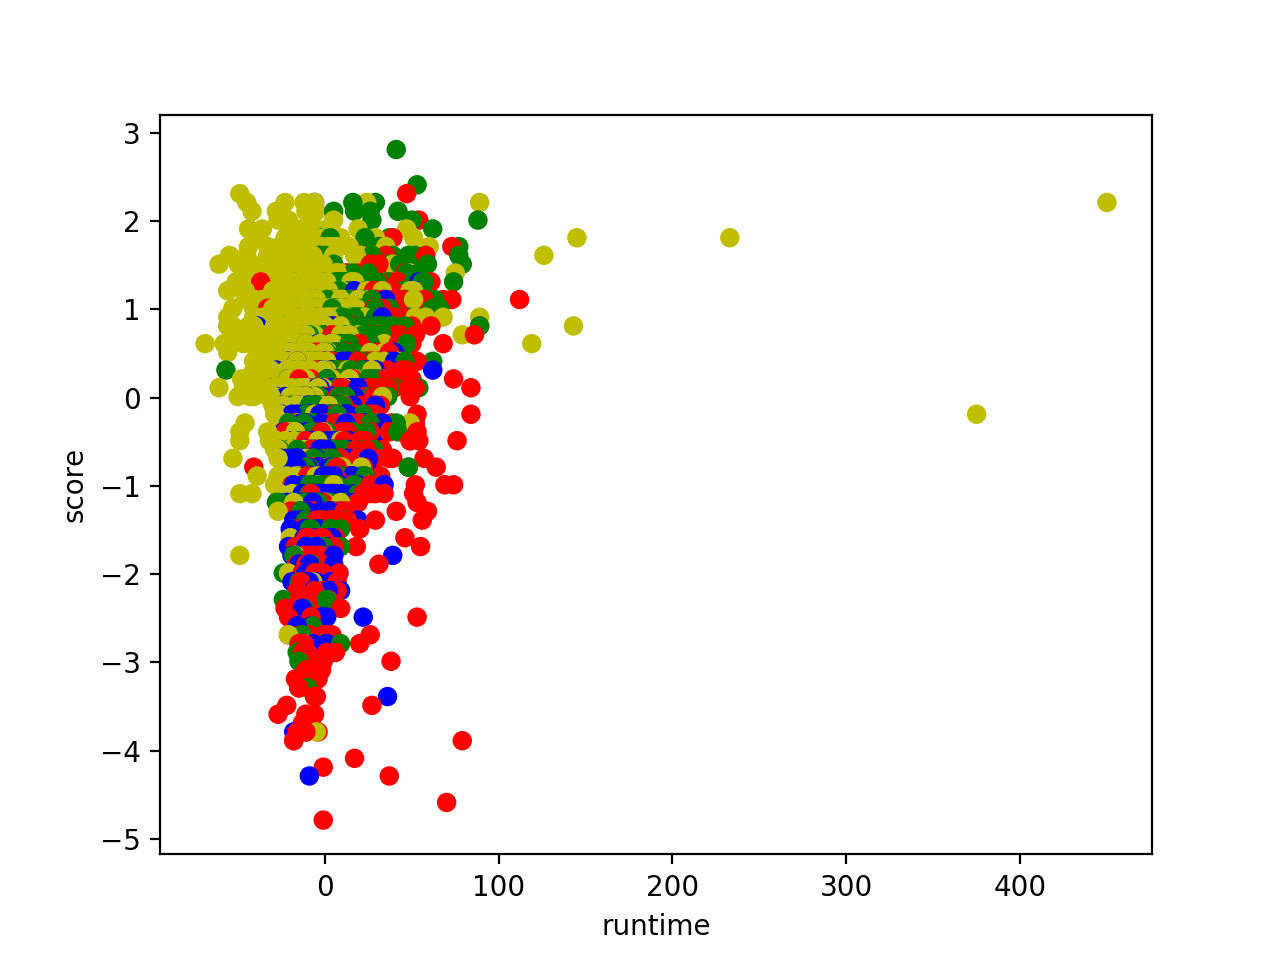

Text(0, 0.5, 'score')

In [157]:
fig2 = plt.figure()
plt.scatter(otherDatac[:,2], otherDatac[:,3], c=colors)
plt.xlabel('runtime')
plt.ylabel('score')

Runtime looks like a good predictor for documentary. Score looks like a semi good predictor for action.

From the results in this document, it seems like title, runtime, and score are good classifiers for docus/bios, action/adv, and maybe romance/comedy.

Shorter run-times (and the occasional extremely long runtime) and higher scores differentiate docu/bio very well from the rest.

Movie rating seems to order the genres as follows:
1. docu/bio
2. drama/crime
3. romance/comedy
4. action/adv


In [161]:
np.savez('dataMau',colors=colors, y=y, Xtfidf=Xtfidf, otherData=otherData)